In [1]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev
import urllib.parse
import urllib.request

import io 

import importlib
import hdbscan
import networkx as nx 
import pickle

import obonet

In [35]:
goa = pd.read_csv( io.BytesIO(gcs.download_blob("functional_sim/data/goa_human.gaf.gz")), 
                                compression='gzip', 
                                header=None,
                                skiprows=41,    # hard-coded. May be different for other gaf files.
                                sep='\t')

goa.columns=["DB", "DB Object ID", "DB Object Symbol", "Qualifier", "GO ID", "Reference", 
                         "Evidence Code", "With or From", "Aspect", "Name", "Synonym", "Type", 
                         "Taxon", "Date", "Assigned By", "Annotation Extension", "Gene Product Form ID"]


/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [137]:
all_protein_combos_per_cluster = gcs.download_parquet(
    'model_outputs/no_cluster_size_limit/B3EP_A-HDBSCAN-CurveNet-all_protein_combos_per_cluster.parquet')

# Functions

In [221]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [222]:
funsim_result = ev.funsim_evaluator(all_protein_combos_per_cluster, goa)

2021-Dec-05 14:46:29 Total number of proteins in GO annotations: 18240
2021-Dec-05 14:46:29 IC_t created
2021-Dec-05 14:46:29 Dictionary of proteins and their GO terms lookup created


In [223]:
funsim_result.funsim()
cluster_funsim, protein_pair_funsim = funsim_result.cluster_funsim, funsim_result.protein_pair_funsim

2021-Dec-05 14:46:33 Funsim calculated.
2021-Dec-05 14:46:34 Funsim summary by cluster done.
2021-Dec-05 14:46:34 Get NP Arr of GO terms for each protein
2021-Dec-05 14:46:34 Turn GO terms into dict
2021-Dec-05 14:46:34 Map GO desc...
2021-Dec-05 14:46:34 Mapping GO desc done.
2021-Dec-05 14:46:34 Common GO term sumary per cluster processed.
2021-Dec-05 14:46:34 Merged cluster-level funsim score with GO summary.


In [224]:
funsim_result.cluster_funsim.head()

,num_pairs,num_pairs_with_funsim,funsim,perc_pairs_w_funsim,cluster,go,num_proteins,go_summary,top_go_id,top_go_name,top_go_count,top_go_occurrence
cluster,,,,,,,,,,,,
0,120,120,0.293619,1.0,0,"{'GO:0002020': 3, 'GO:0003756': 1, 'GO:0003923...",16,"{'GO:0005515': {'Num. Protein': 14, 'Name': 'p...",GO:0005515,protein binding,14.0,0.875000
1,66,66,0.056360,1.0,1,"{'GO:0001850': 1, 'GO:0001851': 1, 'GO:0002020...",12,"{'GO:0005515': {'Num. Protein': 12, 'Name': 'p...",GO:0005515,protein binding,12.0,1.000000
2,10,3,1.000000,0.3,2,{'GO:0005515': 3},5,"{'GO:0005515': {'Num. Protein': 3, 'Name': 'pr...",GO:0005515,protein binding,3.0,0.600000
3,253,253,0.079149,1.0,3,"{'GO:0000210': 2, 'GO:0000287': 7, 'GO:0000298...",23,"{'GO:0005515': {'Num. Protein': 15, 'Name': 'p...",GO:0005515,protein binding,15.0,0.652174
4,10,6,0.132348,0.6,4,"{'GO:0003723': 1, 'GO:0005515': 4, 'GO:0008408...",5,"{'GO:0005515': {'Num. Protein': 4, 'Name': 'pr...",GO:0005515,protein binding,4.0,0.800000


In [226]:
funsim_result.cluster_funsim.top_go_id.value_counts()

GO:0005515    289
GO:0005524     27
GO:0046872     25
GO:0005509     19
GO:0000978     17
             ... 
GO:0050699      1
GO:0019901      1
GO:0030548      1
GO:0004198      1
GO:0045236      1
Name: top_go_id, Length: 283, dtype: int64

In [227]:
funsim_result.cluster_funsim.top_go_id.value_counts().shape

(283,)

In [234]:
funsim_result.cluster_funsim.top_go_name[funsim_result.cluster_funsim.top_go_name.str.len()==79].loc[393]

'RNA polymerase II transcription regulatory region sequence-specific DNA binding'

In [342]:
max(funsim_result.unique_proteins.go.str.len())

36

In [258]:
protein_pair_funsim.head()

,protein_A,protein_B,cluster,funsim
1,Q92851,Q99538,0,0.102652
2,P49662,Q92851,0,0.584883
3,O15519,Q92851,0,0.359714
4,Q14790,Q92851,0,0.518711
5,P55211,Q92851,0,0.461651


### Export

In [ ]:
file_path = 'goa_by_protein_dict.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(funsim_result.goa_by_protein, file)

In [247]:
# Export as CSV. Otherwise fields containing dictionary will have issues. 

cluster_funsim.to_csv('mvp_input/cluster_funsim.csv')

In [42]:
protein_pair_funsim.to_parquet('mvp_input/protein_pair_funsim.parquet')

# Embeddings in 2D, 3D

In [2]:
from sklearn.manifold import Isomap

In [3]:
# Version from Tyler on Wed, Nov 24
curvenet_df = gcs.download_parquet('embeddings/StackedLstmWithSeqVec/embedding_stacked_6_all_200epoch.parquet')
# Convert pd Series into np arr
X_curvenet = np.stack( curvenet_df["curvenet_embeddings"]).astype(np.float64)

protein_id_curvenet = np.array(curvenet_df["protein_id"].str.decode('UTF-8'))
print(X_curvenet.shape)
print(protein_id_curvenet.shape)
print(protein_id_curvenet[:10])


(20352, 1024)
(20352,)
['Q8IWI9' 'Q9NYQ6' 'Q96BY6' 'P52948' 'Q5VT52' 'Q6YHK3' 'Q96M83' 'Q9NYA4'
 'Q9HD43' 'Q7RTR2']


In [5]:
protein_conf = gcs.download_parquet('structure_files/proteins_and_confidences.parquet')

mask = np.isin(protein_id_curvenet,
               np.array(protein_conf[protein_conf.confidence!='D'].protein_id)
              )

print('Mask filter shape for conf > 50:', mask.shape)
print('Number of proteins in curvenet:', protein_id_curvenet.shape)
print('Filtered curvenet:', protein_id_curvenet[mask].shape)
print('X_curvenet original shape:', X_curvenet.shape)
print('X_curvenet filtered shape:', X_curvenet[mask].shape)

protein_id_curvenet = protein_id_curvenet[mask]
X_curvenet = X_curvenet[mask]

Mask filter shape for conf > 50: (20352,)
Number of proteins in curvenet: (20352,)
Filtered curvenet: (19442,)
X_curvenet original shape: (20352, 1024)
X_curvenet filtered shape: (19442, 1024)


In [6]:
print(X_curvenet.shape)
print(protein_id_curvenet.shape)

(19442, 1024)
(19442,)


In [7]:
print("X_full orig shape", X_curvenet.shape)

embedding = Isomap(n_components=3)
curvenet_3d = embedding.fit_transform(X_curvenet)
print("X_transformed new shape", curvenet_3d.shape)

X_full orig shape (19442, 1024)
X_transformed new shape (19442, 3)


In [8]:
print("X_full orig shape", X_curvenet.shape)

embedding = Isomap(n_components=2)
curvenet_2d = embedding.fit_transform(X_curvenet)
print("X_transformed new shape", curvenet_2d.shape)

X_full orig shape (19442, 1024)
X_transformed new shape (19442, 2)


In [16]:
clusters = gcs.download_pkl('model_outputs/no_cluster_size_limit/B3EP_A_clusters.pkl')

In [17]:
clusters_with_coords = pd.concat([clusters,
                                  pd.DataFrame(curvenet_3d, columns=['x3', 'y3', 'z3'])], 
                             axis=1)

clusters_with_coords = pd.concat([clusters_with_coords,
                                  pd.DataFrame(curvenet_2d, columns=['x2', 'y2'])], 
                             axis=1)


In [18]:
clusters_with_coords

,protein,cluster_label,x3,y3,z3,x2,y2
0,Q9NYQ6,-1,-6.230351,-5.041735,5.572204,-6.230351,-5.041735
1,Q96BY6,601,1.959483,-3.639756,-1.735109,1.959483,-3.639756
2,P52948,295,3.753877,-0.698656,-2.425429,3.753877,-0.698656
3,Q6YHK3,8,0.920021,-2.897110,-1.841997,0.920021,-2.897110
4,Q9NYA4,-1,3.668093,-0.442064,-2.907017,3.668093,-0.442064
...,...,...,...,...,...,...,...
19437,P14621,-1,1.662084,0.387236,-0.233648,1.662084,0.387236
19438,Q9NRP2,-1,2.059642,-0.233781,-0.954950,2.059642,-0.233781
19439,P63173,-1,1.600587,0.066254,-2.151213,1.600587,0.066254
19440,P09430,-1,9.690182,-1.799849,-6.119286,9.690182,-1.799849


In [46]:
clusters_with_coords.to_parquet('mvp_input/B3EP_A_proteins_with_coords.parquet')

# Inventory audit

In [23]:
samples_cluster_stats2 = gcs.download_parquet('samples/cluster_stats2.parquet')

In [24]:
samples_cluster_stats2.head()

,D_perc,protein_confidence,count,mean_seq_len,min_seq_len,median_seq_len,max_seq_len,std_seq_len,seq_len_arr,embedding,model,bitscore_mean,bitscore_std_dev,evalue_mean,evalue_std_dev,ratio_pairs_wo_blast
cluster_label,,,,,,,,,,,,,,,,
-1,0.261260,72.521775,11579,640.978668,16,379.0,50384,1865.771342,"[64, 75, 130, 117, 120, 117, 118, 115, 119, 11...",None,None,NaN,NaN,NaN,NaN,NaN
0,0.083798,87.255972,10,420.500000,388,401.0,518,48.413152,"[420, 406, 412, 388, 388, 388, 396, 388, 501, ...",SeqVec,HDBSCAN,277.063333,181.083222,5.233507e-13,3.503063e-12,0.000000
1,0.003968,83.361675,24,18.125000,16,17.0,24,2.383138,"[16, 18, 20, 20, 18, 16, 17, 24, 16, 23, 16, 1...",SeqVec,HDBSCAN,22.803306,2.053531,2.850000e+00,2.656713e+00,0.780797
2,0.811621,43.503500,6,6215.666667,313,1587.5,20861,8544.603903,"[20861, 2391, 784, 12450, 313, 495]",SeqVec,HDBSCAN,93.320213,31.847542,1.607582e-01,9.336660e-01,0.096154
3,0.019166,88.869283,5,175.600000,166,175.0,192,10.784248,"[166, 179, 166, 175, 192]",SeqVec,HDBSCAN,230.000000,90.651215,5.850000e-22,1.083684e-21,0.600000


Protein confidence, sequence length, etc. 

In [28]:
samples_cluster_stats2.shape

(758, 16)

In [33]:
new_cluster_stats2 = gcs.download_parquet('mvp_input/2021_1204/B3EP_A-HDBSCAN-CurveNet-cluster_stats.parquet')

In [34]:
new_cluster_stats2.head()

,model,embedding,num_proteins,D_perc,protein_confidence,mean_seq_len,min_seq_len,median_seq_len,max_seq_len,std_seq_len,seq_len_arr,bitscore_mean,bitscore_std_dev,evalue_mean,evalue_std_dev,ratio_pairs_wo_blast
cluster_label,,,,,,,,,,,,,,,,
-1.0,HDBSCAN,CurveNet,8802,0.231568,73.967563,576.160304,16,372.0,47568,1524.298431,"[13814, 1195, 924, 803, 737, 706, 674, 650, 63...",NaN,NaN,NaN,NaN,NaN
0.0,HDBSCAN,CurveNet,16,0.160317,80.669787,416.937500,242,410.0,824,134.827034,"[521, 433, 377, 480, 479, 416, 242, 293, 395, ...",115.219375,85.904224,0.092664,0.593138,0.333333
1.0,HDBSCAN,CurveNet,12,0.099938,81.643986,371.083333,129,343.5,893,182.813595,"[339, 428, 291, 348, 356, 427, 383, 129, 299, ...",123.298913,141.203734,0.778859,1.910282,0.651515
2.0,HDBSCAN,CurveNet,5,0.106305,79.897790,317.800000,289,299.0,392,43.031384,"[291, 392, 318, 299, 289]",179.600000,141.162131,0.022167,0.071877,0.400000
3.0,HDBSCAN,CurveNet,23,0.083594,88.840144,245.565217,147,222.0,462,85.656198,"[164, 211, 227, 180, 227, 164, 181, 219, 352, ...",73.689474,91.561678,0.925611,1.837667,0.699605


In [25]:
samples_proteins_w_blast = gcs.download_parquet('samples/proteins_w_blast.parquet')

In [26]:
samples_proteins_w_blast.head()

,query_protein,target_protein,cluster,bitscore,evalue
0,O96009,P00797,0,312.0,2.770000e-103
1,O96009,P07339,0,390.0,1.150000e-133
2,O96009,P0DJD7,0,290.0,3.770000e-95
3,O96009,P0DJD8,0,291.0,2.610000e-95
4,O96009,P0DJD9,0,292.0,9.250000e-96


Danie took care of this.

In [47]:
sequences = gcs.download_parquet('structure_files/sequences/sequences.parquet')

In [48]:
sequences.head()

,pdbx_db_accession,db_code,db_name,protein_id,pdbx_seq_one_letter_code,protein_filename,confidence_pLDDT
0,A0A024R1R8,A0A024R1R8_HUMAN,UNP,A0A024R1R8,MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAK...,AF-A0A024R1R8-F1-model_v1,73.21
1,A0A024RBG1,NUD4B_HUMAN,UNP,A0A024RBG1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,AF-A0A024RBG1-F1-model_v1,85.18
2,A0A024RCN7,A0A024RCN7_HUMAN,UNP,A0A024RCN7,MERSFVWLSCLDSDSCNLTFRLGEVESHACSPSLLWNLLTQYLPPG...,AF-A0A024RCN7-F1-model_v1,54.38
3,A0A075B6H5,A0A075B6H5_HUMAN,UNP,A0A075B6H5,METVVTTLPREGGVGPSRKMLLLLLLLGPGSGLSAVVSQHPSRVIC...,AF-A0A075B6H5-F1-model_v1,86.88
4,A0A075B6H7,KV37_HUMAN,UNP,A0A075B6H7,MEAPAQLLFLLLLWLPDTTREIVMTQSPPTLSLSPGERVTLSCRAS...,AF-A0A075B6H7-F1-model_v1,90.02


In [49]:
pairwise_evaluation_metrics = gcs.download_parquet('annotations/pairwise_evaluation_metrics.parquet')

In [50]:
pairwise_evaluation_metrics.head()

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


# Graphs

In [51]:
cluster_stats_1 = gcs.download_parquet('mvp_input/2021_1204/B3EP_A-HDBSCAN-CurveNet-cluster_stats.parquet')

In [281]:
cluster_stats_2 = pd.read_csv(io.BytesIO(gcs.download_blob('mvp_input/2021_1204/cluster_funsim.csv')))

In [261]:
cluster_stats_1.shape

(834, 16)

In [282]:
cluster_stats_2.shape

(833, 13)

In [295]:
pairwise_eval = gcs.download_parquet('mvp_input/2021_1204/B3EP_A_PairwiseStats.parquet')

In [296]:
pairwise_eval.head()

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score,hit_span_mean,bitscore_mean,evalue_mean
0,AF-Q92851-F1-model_v1,AF-Q99538-F1-model_v1,0,521.0,433.0,182.0,4.11,0.30039,NaN,NaN,NaN
1,AF-Q92851-F1-model_v1,AF-P49662-F1-model_v1,0,521.0,377.0,250.0,4.28,0.41562,221.0,65.9,1.680000e-11
2,AF-Q92851-F1-model_v1,AF-O15519-F1-model_v1,0,521.0,480.0,191.0,3.11,0.33610,440.0,105.0,2.920000e-24
3,AF-Q92851-F1-model_v1,AF-Q14790-F1-model_v1,0,521.0,479.0,248.0,4.43,0.41147,435.0,241.0,1.460000e-73
4,AF-Q92851-F1-model_v1,AF-P55211-F1-model_v1,0,521.0,416.0,215.0,3.81,0.37304,216.0,114.0,1.490000e-27


In [297]:
cluster_eval = pairwise_eval.pivot_table(
    index='cluster',
    values=['rmsd', 'tmalign_score', 'bitscore_mean', 'evalue_mean'],
    aggfunc=np.mean
)

cluster_eval

,bitscore_mean,evalue_mean,rmsd,tmalign_score
cluster,,,,
0,115.219375,0.092664,2.982583,0.535021
1,123.298913,0.778859,3.680000,0.459959
2,179.600000,0.022167,3.290000,0.748890
3,73.689474,0.925611,3.248725,0.532235
4,219.875000,0.000002,NaN,NaN
...,...,...,...,...
828,268.612296,0.019874,4.855155,0.429232
829,74.956467,0.276832,6.169636,0.278712
830,107.300000,3.475000,4.864167,0.294018


In [356]:
cluster_stats = cluster_stats_1[['num_proteins', 'D_perc', 'protein_confidence',
       'median_seq_len',
       'std_seq_len']
    ].merge(cluster_stats_2[['cluster', 'funsim']],
            left_index=True,
            right_on='cluster'
    ).merge(cluster_eval,
           left_index=True,
           right_index=True,
           how='left')

In [357]:
cluster_stats

,num_proteins,D_perc,protein_confidence,median_seq_len,std_seq_len,cluster,funsim,bitscore_mean,evalue_mean,rmsd,tmalign_score
0,16,0.160317,80.669787,410.0,134.827034,0,0.293619,115.219375,0.092664,2.982583,0.535021
1,12,0.099938,81.643986,343.5,182.813595,1,0.056360,123.298913,0.778859,3.680000,0.459959
2,5,0.106305,79.897790,299.0,43.031384,2,1.000000,179.600000,0.022167,3.290000,0.748890
3,23,0.083594,88.840144,222.0,85.656198,3,0.079149,73.689474,0.925611,3.248725,0.532235
4,5,0.229143,78.375650,298.0,96.391390,4,0.132348,219.875000,0.000002,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
828,423,0.299617,67.539479,561.0,161.669876,828,0.513221,268.612296,0.019874,4.855155,0.429232
829,9,0.358227,62.367330,619.0,458.157451,829,0.272137,74.956467,0.276832,6.169636,0.278712
830,5,0.259113,75.345309,488.0,123.603398,830,0.247875,107.300000,3.475000,4.864167,0.294018
831,18,0.219954,74.440214,832.5,589.531918,831,0.063514,121.370000,2.823874,6.452989,0.250113


In [360]:
cluster_stats['bitscore_good'] = cluster_stats.bitscore_mean > 50
cluster_stats['tmalign_good'] = cluster_stats.tmalign_score > 0.5
cluster_stats['rmsd_good'] = cluster_stats.rmsd < 3.
cluster_stats.to_parquet('mvp_input/cluster_stats_haerang.parquet')

In [337]:
cluster_stats.columns

Index(['num_proteins', 'D_perc', 'protein_confidence', 'median_seq_len',
       'std_seq_len', 'cluster', 'funsim', 'bitscore_mean', 'evalue_mean',
       'rmsd', 'tmalign_score', 'log_rmsd', 'log_num_proteins'],
      dtype='object')

In [310]:
np.log(cluster_stats["rmsd"])

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0      1.092790
1      1.302913
2      1.190888
3      1.178263
4           NaN
         ...   
828    1.580041
829    1.819640
830    1.581895
831    1.864543
832    1.880371
Name: rmsd, Length: 833, dtype: float64

In [273]:
import seaborn as sns

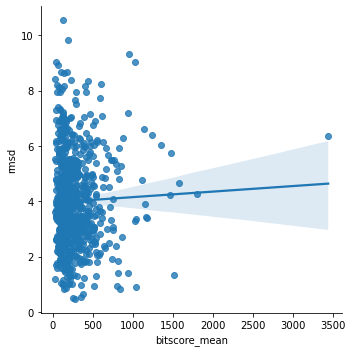

In [334]:
sns.lmplot(data=cluster_stats, 
                x="bitscore_mean", 
                y='rmsd'
               )

<AxesSubplot:xlabel='bitscore_mean', ylabel='rmsd'>

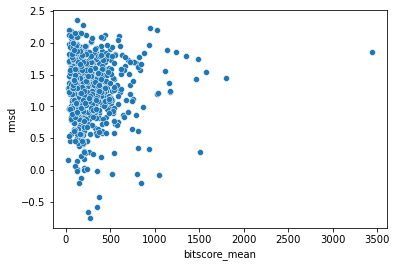

In [311]:
sns.scatterplot(data=cluster_stats, 
                x="bitscore_mean", 
                y=np.log(cluster_stats["rmsd"])
               )

(0.0, 2000.0)

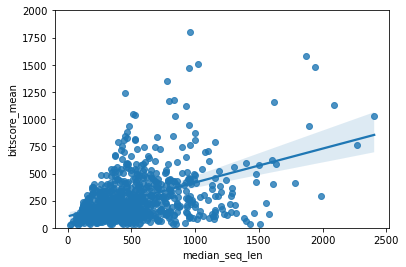

In [426]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="bitscore_mean"

p = sns.regplot(data=cluster_stats[
    cluster_stats.median_seq_len < 8000], 
           x=x,
           y=y,
               )
p.set_ylim(0, 2000)
              

(0.0, 2000.0)

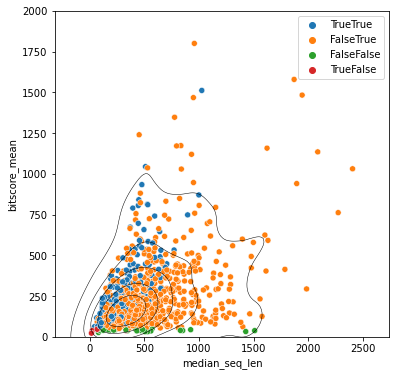

In [433]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="bitscore_mean"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good.astype(str) 
                         + cluster_stats.bitscore_good.astype(str))
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)
ax.set_ylim(0, 2000)

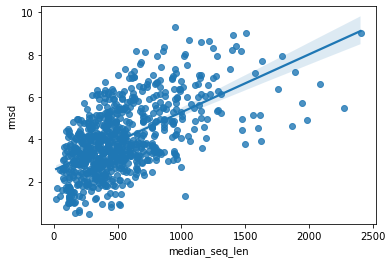

In [421]:
p = sns.regplot(data=cluster_stats[
    cluster_stats.median_seq_len < 8000],  
           x="median_seq_len",
           y="rmsd",
               )
              

<AxesSubplot:xlabel='median_seq_len', ylabel='rmsd'>

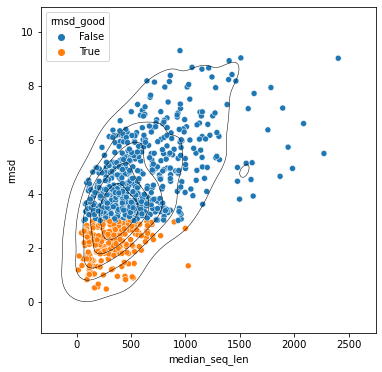

In [423]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="rmsd"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)

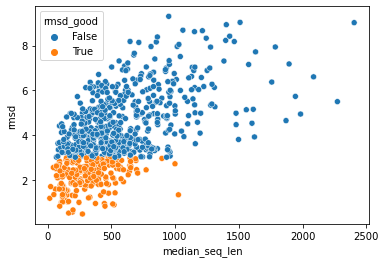

In [424]:
p = sns.scatterplot(data=cluster_stats[
    cluster_stats.median_seq_len < 8000],   
           x="median_seq_len",
           y="rmsd",
           hue='rmsd_good'
               )

(0.0, 10.0)

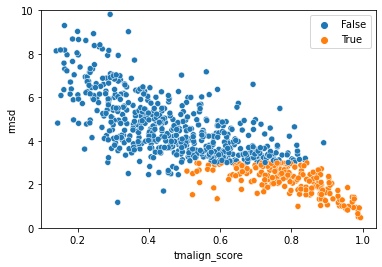

In [382]:
p = sns.scatterplot(data=cluster_stats, 
                    x="tmalign_score",
                    y="rmsd",
                    hue=(cluster_stats.rmsd_good
                        ) & (cluster_stats.tmalign_good)
               
                   )
p.set_ylim(0, 10)

<AxesSubplot:xlabel='tmalign_score', ylabel='rmsd'>

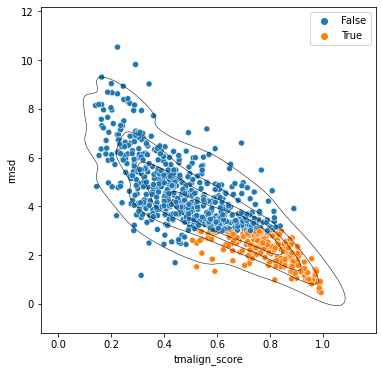

In [406]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good
                        ) & (cluster_stats.tmalign_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)

<AxesSubplot:xlabel='tmalign_score', ylabel='rmsd'>

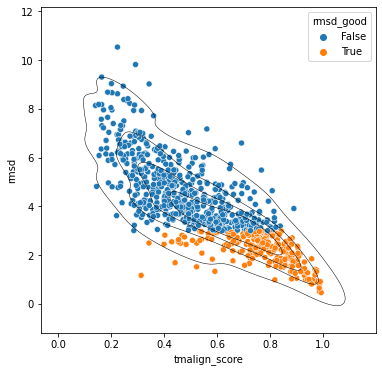

In [418]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)

<AxesSubplot:xlabel='tmalign_score', ylabel='rmsd'>

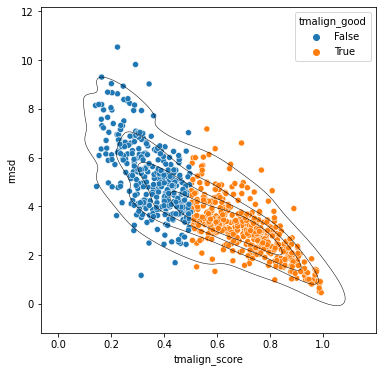

In [419]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.tmalign_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)

<AxesSubplot:xlabel='tmalign_score', ylabel='rmsd'>

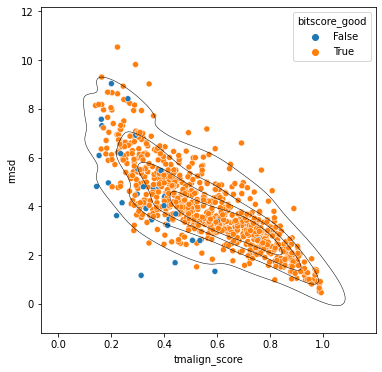

In [420]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.bitscore_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)

In [344]:
cluster_stats.tmalign_score.describe()

count    774.000000
mean       0.550104
std        0.208400
min        0.140095
25%        0.377097
50%        0.544007
75%        0.718766
max        0.993640
Name: tmalign_score, dtype: float64

<AxesSubplot:xlabel='median_seq_len', ylabel='bitscore_mean'>

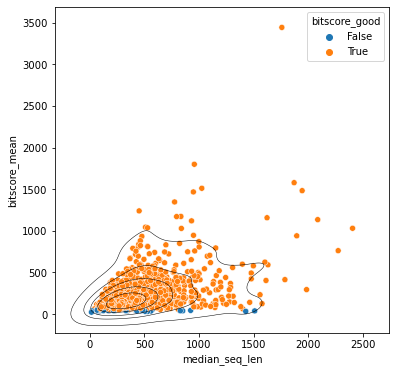

In [417]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="bitscore_mean"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=(cluster_stats.bitscore_good),
                )
f.set_ylim=(-200, 2000)
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)


<AxesSubplot:xlabel='bitscore_mean', ylabel='median_seq_len'>

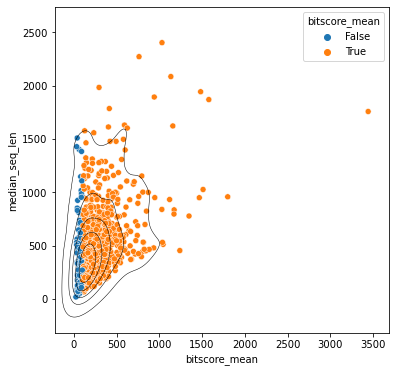

In [416]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="bitscore_mean"
y="median_seq_len"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=(cluster_stats.bitscore_mean > 100),
                )
f.set_xlim=(-200, 2000)
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)


<AxesSubplot:>

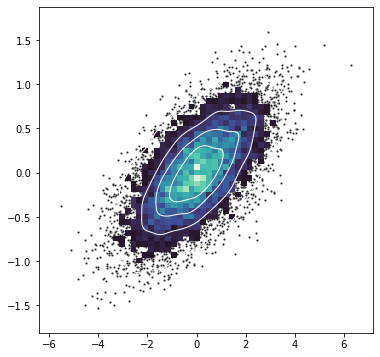

In [384]:
import matplotlib.pyplot as plt
# Simulate data from a bivariate Gaussian
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, .2)]
rng = np.random.RandomState(0)
x, y = rng.multivariate_normal(mean, cov, n).T

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

<AxesSubplot:>

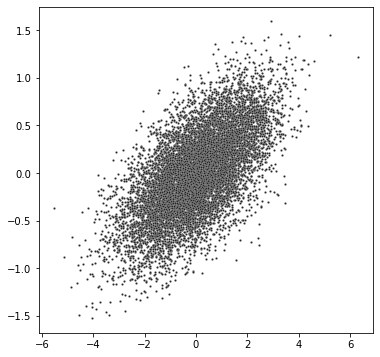

In [385]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")


<AxesSubplot:>

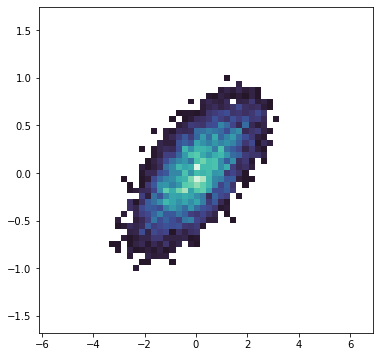

In [386]:
f, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

<AxesSubplot:>

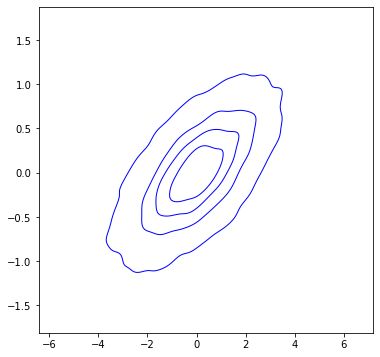

In [388]:
f, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(x=x, y=y, s=5, color=".15")
# sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="b", linewidths=1)

# Model Comparison Graphs

In [473]:
modeloutput = pd.read_csv('Results - Model Outputs.tsv', 
                          sep='\t',
                         header=3, thousands=',')

# Remove NA
# Remove "Do not use" embeddings (CurveNet)
# Select just a few cols

modeloutput=modeloutput[~modeloutput.goodplace_pairs_pct.isna()][
    ['id', 'model', 'embedding', 'largest_clus', 'proteins',
       'clusters', 'silhouette', 'db',
       'noise_pct', 'func_sim', 
       'goodplace_pairs_pct', 'goodplace_clusters_pct',
       'metrics_coverage_pct']]
modeloutput = modeloutput[~modeloutput.embedding.str.contains('DO NOT USE')]

In [474]:
modeloutput.head()

,id,model,embedding,largest_clus,proteins,clusters,silhouette,db,noise_pct,func_sim,goodplace_pairs_pct,goodplace_clusters_pct,metrics_coverage_pct
2,A2EP,DBSCAN,SeqVec,691.0,19515.0,1534.0,0.37,0.75,0.6299,0.3943,0.6078,0.4437,0.6532
4,A1EP,DBSCAN,DeepFold,4571.0,19325.0,1221.0,0.00,0.93,0.5135,0.0508,0.0372,0.5711,0.0241
6,A3EP,DBSCAN,Structure LSTM + SeqVec,232.0,19442.0,714.0,0.55,0.48,0.8792,0.7392,0.8735,0.5855,0.8043
10,B2EP,HDBSCAN,SeqVec,416.0,19515.0,741.0,0.23,1.36,0.5555,0.5021,0.5686,0.2363,0.8117
11,B2EPA,HDBSCAN,SeqVec,401.0,19515.0,314.0,0.32,1.10,0.6898,0.4601,0.4423,0.3131,0.6491


In [486]:
from sklearn.linear_model import LinearRegression


In [498]:
        modeloutput[x].values

array([1534., 1221.,  714.,  741.,  314.,  284.,  184.,  233.,  120.,
        833.,  358.,  630.,  222., 3948., 1631.,  622., 3231., 1165.,
        336.])

In [499]:
regr = LinearRegression()
regr.fit(modeloutput[x].values.reshape(-1, 1),
        modeloutput[y]) 

LinearRegression()

In [500]:
regr.coef_

array([-6.30276256e-05])

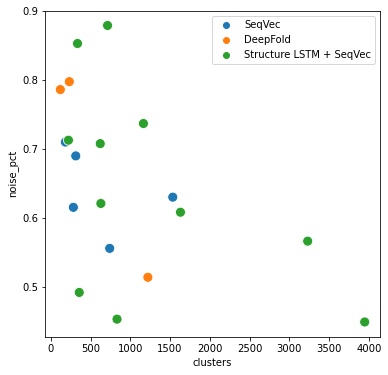

In [484]:
data=modeloutput
x="clusters"
y="noise_pct"
hue='embedding'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=100
                )
ax.legend(loc='upper right')
#f.set_xlim=(-200, 2000)